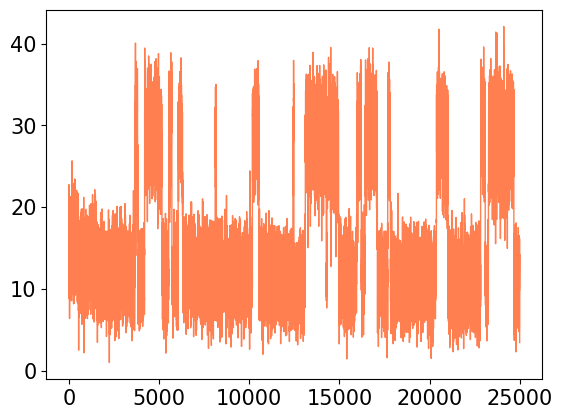

0.021832694928735175


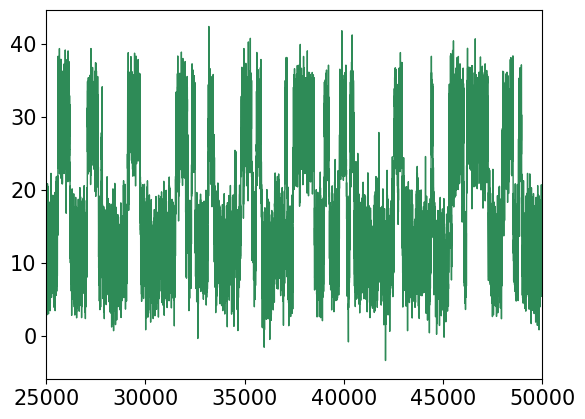

In [1]:
import numpy as np
import networkx as nx
import os.path
import matplotlib.pyplot as plt
import time
import gc
gc.collect()
import warnings
warnings.filterwarnings("ignore")
import os
os.system('cls' if os.name == 'nt' else 'clear')
plt.rc('font',size=15)

UseDoubleWell=1
RCType=0# Different RC architecture: 0 deterministic RC to learn noise; 1/2 with noise in/out side tanh
TrainLength=25000  
TestLength=100000 
T2 = TrainLength + TestLength  # Total time length: including training phase and test/validation phase
anoise=[]


start = time.time() 
np.random.seed(42)
def DoubleWell(): #Load data
    dimensions = 1
    # U = np.load(r'../data/real data of protein folding/datafordistribution.npy')
    U = np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\datafordistribution.npy')

    u = U[:TrainLength]
    u = u.reshape(dimensions,TrainLength)
    U = U.reshape(dimensions,-1)
    tick=np.linspace(0,TrainLength,6)
    plt.plot(u[0,:],color='coral',linewidth=1,linestyle='-')
    plt.xticks(tick)
    #plt.savefig('rtrain.pdf',bbox_inches = 'tight',dpi=600)
    plt.show()
    return u  

class Reservoir:
    def __init__(self,Utotal,hyperparameters):      
        # Input layer
        self.NumBifurPara=np.shape(Utotal)[0]       
        self.M = u.shape[0]  
        self.input_len = u.shape[1]
        self.dataset = Utotal

        # Reservoir layer
        self.N = 800
        self.dimensions = 1
        self.P = u.shape[0]
        self.bias = 0
        
        # Training relevant: have used their ratio of separating the input data
        self.init_len = 0
        self.train_len = TrainLength-1
        self.test_len = np.int(TestLength)
        self.error_len = np.int(TestLength)
        self.T2=self.input_len
        
        # Hyperparameters to be optimized: here set their initial value of hyperparameters
        self.kin =hyperparameters[0] # uniform distribution of $[-k_{in},k_{in}]$ of W_{in}, W_{b}, W_{\epsilon}
        self.D = hyperparameters[1] # degree of reservoir matrix A ... self.degree_func(self.N) #What is the degree function in their code: the degree of the renyi-Erdos network
        self.rho = hyperparameters[2] # spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.alpha =hyperparameters[3] 
        self.beta = hyperparameters[4] 
        self.parab=0 #set as zero for now, because no para-layer yet
        self.parak=0 #set as zero for now, because no para-layer yet
        self.paraepsilon=0 #epsilon for RC and consistent with SDE model

        
    def train(self,parascanRange): #To train W_{out}
        self.Win =np.random.uniform(-self.kin,self.kin, (self.N, self.M + 1))
        self.Wb= np.random.uniform(-self.kin, self.kin, (self.N, 1))
        self.Wxi=np.random.uniform(-self.kin,self.kin, (self.N, self.M))  
        # TODO: the values of non-zero elements are randomly drawn from uniform dist [-1, 1]
        g = nx.erdos_renyi_graph(self.N, self.D / self.N, 42, True)
        self.A = nx.adjacency_matrix(g).todense()
        # spectral radius: rho  -> "appropriately scaled by its largest eigenvalue ρ."
        self.A =self.A *1.25 /self.rho
        print(max(abs(np.linalg.eig(self.A)[0])))
        
        # run the reservoir with the data and collect r
        self.rFinalTrainTotal=[]
        for index in range(self.NumBifurPara):
            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len-self.init_len ))
                # collection of input signals
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
                Xi= np.random.normal(0,1, (self.M, 1))#Gaussian white noise
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                if RCType==1:
                    #RC1: noise inside tanh
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab)
                          + np.sqrt(self.paraepsilon)*np.dot(self.Wxi,Xi))            
                if RCType==2:
                    #RC2: noise outside tanh
                    self.r = (1 - self.alpha) * self.r + self.alpha * (np.tanh(np.dot(self.A,self.r) 
                         + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                         + np.sqrt(self.paraepsilon)*np.dot(self.Wxi,Xi)) 
                if t >= self.init_len:
                    self.R[:, [t - self.init_len]
                           ] = np.vstack((self.bias, V, self.r))[:, 0]
            if index==0:
                self.RTotal=self.R
                self.STotal=self.S             
            else:            
                self.RTotal=np.append(self.RTotal,self.R, axis=1)
                self.STotal=np.append(self.STotal,self.S, axis=1)
            self.rFinalTrainTotal.append(self.r[:,-1])

        # train the output
        R = self.RTotal  # Transpose
        R_T=R.T        
        self.Wout = np.dot(np.dot(self.STotal, R_T), np.linalg.inv(
            np.dot(self.RTotal, R_T) + self.beta * np.eye(self.M + self.N + 1)))
        return self.Wout

    def train2(self,WoutPara): #Seperate noise
        global t
        self.SampledNoise = []
        for index in range(self.NumBifurPara):

            self.paralayer=parascanRange[index]
            self.R = np.zeros(
                    (1 + self.N + self.M, self.train_len - self.init_len))
            self.S = np.vstack((x[self.init_len + 1: self.train_len + 1] for x in self.dataset[index])) # make multi-dimensional input data from training window
            self.r = np.zeros((self.N, 1))
            for t in range(self.train_len):
                V = np.vstack((x[t] for x in self.dataset[index]))
             
                #RC0: 0 deterministic RC to learn noise
                self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))
                self.S[:, t] = np.squeeze(np.asarray(s))                
            for i in range(self.dimensions):
              X=self.dataset[index][np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 1: self.train_len + 1]
              Y=self.S[np.array(range(int(self.P/self.dimensions)))*self.dimensions+i, 0: self.train_len ] ####    #self.dataset[range(self.P)*self.dimensions+i, self.train_len+1: self.train_len+self.error_len+1]
              SampledNoise=[]
              for j in range(X.shape[1]):
                  XX=np.array(X[:,j])  
                  YY=np.array(Y[:,j])
                  NoiseTemp=XX-YY
                  Bins=max(5,int(np.sqrt(X.shape[0])))
                  hist, bins = np.histogram(NoiseTemp, bins=Bins,range=(min(NoiseTemp),max(NoiseTemp)), density=True)#np.histogram(data, bins=50)
                  bin_midpoints = bins[:-1] + np.diff(bins)/2
                  cdf = np.cumsum(hist)
                  cdf = cdf / cdf[-1]
                  values = np.random.rand(X.shape[0])
                  value_bins = np.searchsorted(cdf, values)
                  random_from_cdf = bin_midpoints[value_bins]
                  if j<0:#show the fitting to the noise distribution
                        plt.subplot(121)
                        plt.hist(NoiseTemp, Bins)
                        plt.subplot(122)
                        plt.hist(random_from_cdf, Bins)
                        plt.show()
                  SampledNoise.append(random_from_cdf)
              self.SampledNoise.append(SampledNoise) 
              
        
    
    def _run(self,WoutPara,Load,Predict):       
        # run the trained ESN in alpha generative mode. no need to initialize here,
        # because r is initialized with training data and we continue from there.
        output=[]
        if Load==0:
            np.save(r'../data/real data of protein folding/rWinw.npy',self.Win)
            np.save(r'../data/real data of protein folding/rAw.npy',self.A)
            np.save(r'../data/real data of protein folding/rWoutParaw.npy',WoutPara)            
            np.save(r'../data/real data of protein folding/rWb.npy',self.Wb)
            np.save(r'../data/real data of protein folding/rWxi.npy',self.Wxi)
            np.save(r'../data/real data of protein folding/rr.npy',self.rFinalTrainTotal)
        else:

            self.Win=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rWinw.npy')
            self.A=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rAw.npy')
            WoutPara=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rWoutParaw.npy')
            self.Wb=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rWb.npy')
            self.Wxi=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rWxi.npy')
            self.rFinalTrainTotal=np.load(r'D:\NIT-RC-main\NIT-RC-main\data\real data of protein folding\rr.npy')

        self.S = np.zeros((self.P, self.test_len))
        self.S_1 = np.zeros((self.P, self.test_len))
        self.S_2 = np.zeros((self.P, self.test_len))
        self.S_3 = np.zeros((self.P, self.test_len))
        self.S_4 = np.zeros((self.P, self.test_len))
        self.S_5 = np.zeros((self.P, self.test_len))
        self.S_6 = np.zeros((self.P, self.test_len))
        self.S_7 = np.zeros((self.P, self.test_len))
        self.S_8 = np.zeros((self.P, self.test_len))
        self.S_9 = np.zeros((self.P, self.test_len))
        
        for index in range(self.NumBifurPara):
            V = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_1 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_2 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_3 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_4 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_5 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_6 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_7 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_8 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            V_9 = np.vstack((x[self.train_len] for x in self.dataset[index]))
            
            V[:,0]=20
            if Predict == 0:
                V[:,0]=4
                V_1[:,0]=8
                V_2[:,0]=12
                V_3[:,0]=16
                V_4[:,0]=20
                V_5[:,0]=24
                V_6[:,0]=28
                V_7[:,0]=32
                V_8[:,0]=36
                V_9[:,0]=40
                        
            if Predict == 0:
                self.r=self.rFinalTrainTotal[index]
                self.r_1=self.rFinalTrainTotal[index]
                self.r_2=self.rFinalTrainTotal[index]
                self.r_3=self.rFinalTrainTotal[index]
                self.r_4=self.rFinalTrainTotal[index]
                self.r_5=self.rFinalTrainTotal[index]
                self.r_6=self.rFinalTrainTotal[index]
                self.r_7=self.rFinalTrainTotal[index]
                self.r_8=self.rFinalTrainTotal[index]
                self.r_9=self.rFinalTrainTotal[index]
            else:
                self.r=self.rFinalTrainTotal[index]*0

            
            if RCType==0:
                
                global NoiseToUse
                NoiseToUse=np.array(self.SampledNoise)

            for t in range(self.test_len):
                # r(t + \Delta t) = (1 - alpha)r(t) + alpha * tanh(A * r(t) + Win * V(t) + bias)
                if RCType==0:
                    #RC0: 0 deterministic RC to learn noise
                    self.r = (1 - self.alpha) * self.r + self.alpha * np.tanh(np.dot(self.A,self.r) 
                          + np.dot(self.Win, np.vstack((self.bias, V)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                                          
                    if Predict == 0:
                    
                        self.r_1 = (1 - self.alpha) * self.r_1 + self.alpha * np.tanh(np.dot(self.A,self.r_1) 
                              + np.dot(self.Win, np.vstack((self.bias, V_1)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_2 = (1 - self.alpha) * self.r_2 + self.alpha * np.tanh(np.dot(self.A,self.r_2) 
                              + np.dot(self.Win, np.vstack((self.bias, V_2)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                              
                        self.r_3 = (1 - self.alpha) * self.r_3 + self.alpha * np.tanh(np.dot(self.A,self.r_3) 
                              + np.dot(self.Win, np.vstack((self.bias, V_3)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_4 = (1 - self.alpha) * self.r_4 + self.alpha * np.tanh(np.dot(self.A,self.r_4) 
                              + np.dot(self.Win, np.vstack((self.bias, V_4)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_5 = (1 - self.alpha) * self.r_5 + self.alpha * np.tanh(np.dot(self.A,self.r_5) 
                              + np.dot(self.Win, np.vstack((self.bias, V_5)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_6 = (1 - self.alpha) * self.r_6 + self.alpha * np.tanh(np.dot(self.A,self.r_6) 
                              + np.dot(self.Win, np.vstack((self.bias, V_6)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_7 = (1 - self.alpha) * self.r_7 + self.alpha * np.tanh(np.dot(self.A,self.r_7) 
                              + np.dot(self.Win, np.vstack((self.bias, V_7)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_8 = (1 - self.alpha) * self.r_8 + self.alpha * np.tanh(np.dot(self.A,self.r_8) 
                              + np.dot(self.Win, np.vstack((self.bias, V_8)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
                        
                        self.r_9 = (1 - self.alpha) * self.r_9 + self.alpha * np.tanh(np.dot(self.A,self.r_9) 
                              + np.dot(self.Win, np.vstack((self.bias, V_9)))+self.parak*np.dot(self.Wb, self.paralayer+self.parab))
               
                
                if np.isnan(np.sum(np.sum(np.array(self.r)))):
                    print('R')
                    print(np.max(V))
                    print(np.max(np.max(WoutPara)),np.min(np.min(WoutPara)))

                s = np.dot(WoutPara, np.vstack((self.bias, V, self.r)))  
                if Predict ==0:
                    
                    s_1 = np.dot(WoutPara, np.vstack((self.bias, V_1, self.r_1)))
                    s_2 = np.dot(WoutPara, np.vstack((self.bias, V_2, self.r_2)))
                    s_3 = np.dot(WoutPara, np.vstack((self.bias, V_3, self.r_3)))
                    s_4 = np.dot(WoutPara, np.vstack((self.bias, V_4, self.r_4)))
                    s_5 = np.dot(WoutPara, np.vstack((self.bias, V_5, self.r_5)))
                    s_6 = np.dot(WoutPara, np.vstack((self.bias, V_6, self.r_6)))
                    s_7 = np.dot(WoutPara, np.vstack((self.bias, V_7, self.r_7)))
                    s_8 = np.dot(WoutPara, np.vstack((self.bias, V_8, self.r_8)))
                    s_9 = np.dot(WoutPara, np.vstack((self.bias, V_9, self.r_9)))
                
                
                
                self.S[:, t] = np.squeeze(np.asarray(s))
                if Predict ==0:
                    self.S_1[:, t] = np.squeeze(np.asarray(s_1))
                    self.S_2[:, t] = np.squeeze(np.asarray(s_2))
                    self.S_3[:, t] = np.squeeze(np.asarray(s_3))
                    self.S_4[:, t] = np.squeeze(np.asarray(s_4))
                    self.S_5[:, t] = np.squeeze(np.asarray(s_5))
                    self.S_6[:, t] = np.squeeze(np.asarray(s_6))
                    self.S_7[:, t] = np.squeeze(np.asarray(s_7))
                    self.S_8[:, t] = np.squeeze(np.asarray(s_8))
                    self.S_9[:, t] = np.squeeze(np.asarray(s_9))
                
                              
                if RCType==0:
                   
                    self.S[:, t] = self.S[:, t]
                    if Predict ==0:
                        self.S_1[:, t] = self.S_1[:, t]
                        self.S_2[:, t] = self.S_2[:, t]
                        self.S_3[:, t] = self.S_3[:, t]
                        self.S_4[:, t] = self.S_4[:, t]
                        self.S_5[:, t] = self.S_5[:, t]
                        self.S_6[:, t] = self.S_6[:, t]
                        self.S_7[:, t] = self.S_7[:, t]
                        self.S_8[:, t] = self.S_8[:, t]
                        self.S_9[:, t] = self.S_9[:, t]
                    
                 
                xjp = np.random.randint(0, TrainLength-1)
                
                if Predict == 0:
                    V = s
                    V_1= s_1 
                    V_2 = s_2
                    V_3 = s_3
                    V_4 = s_4
                    V_5 = s_5
                    V_6 = s_6
                    V_7 = s_7
                    V_8 = s_8
                    V_9 = s_9
                else:
                    
                    V = s + NoiseToUse[0,xjp,0]
                    anoise.append(NoiseToUse[0,xjp,0])
                    output.append(V)
                    
            if Predict == 1:
                output=np.array(output)
                Output=output.reshape(1,self.test_len)
                
            if Predict == 0:
                xtimes=np.linspace(T2-TestLength,int(T2),self.test_len)
                plt.plot(xtimes,self.S[0,:],color='red',linewidth=1,linestyle='-') 
                plt.plot(xtimes,self.S_1[0,:],color='blue',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_2[0,:],color='green',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_3[0,:],color='black',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_4[0,:],color='grey',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_5[0,:],color='yellow',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_6[0,:],color='pink',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_7[0,:],color='purple',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_8[0,:],color='orange',linewidth=1,linestyle='-')
                plt.plot(xtimes,self.S_9[0,:],color='brown',linewidth=1,linestyle='-')
                tick=np.linspace(T2-TestLength,T2-TestLength+500,6)
                plt.xlim(T2-TestLength,T2-TestLength+500)
                plt.xticks(tick)
                # plt.savefig('../results/deterministic.pdf',bbox_inches = 'tight')
                plt.show()
                
            else:
                xtimes=np.linspace(T2-TestLength,int(T2),self.test_len)
                # np.save(r'predicted.npy',Output[0,:])  #To evaluate transitions in code 'distribution'
                plt.plot(xtimes,Output[0,:],color='seagreen',linewidth=1,linestyle='-')
                tick=np.linspace(T2-TestLength,T2-TestLength+TrainLength,6)
                plt.xlim(T2-TestLength,T2-TestLength+TrainLength)
                plt.xticks(tick)
                # plt.savefig('../results/prediction.pdf',bbox_inches = 'tight')
                plt.show()
                
            # noise distribution
            #NoiseToUse_=np.squeeze(NoiseToUse)
            #a=NoiseToUse_
            #left = np.min(a)
            #right = np.max(a)
            #bins = np.arange(left , right , 0.8)
            #plt.figure(num=None,  dpi=400, edgecolor='k')
            #fig, axes = plt.subplots(1,1)
            #fig.tight_layout()
            #plt.hist(a, bins=bins, density=True, color='seagreen')
            #plt.savefig('rdnoise.pdf',bbox_inches = 'tight')
            #plt.show()



def GenerateEnsemble(Realizations):
    for j in range(Realizations):
        uTemp=DoubleWell() 
        if j==0:
            u=uTemp
        else:
            u=np.vstack((u, uTemp))
    return u

    
if __name__ == '__main__':
    
    if UseDoubleWell==1:
    
        for i in range (1):
            Realizations=1
            parascanRange=[0.2]
            BinNumber=4
            Utotal=[]
            
            rcpara = np.zeros(5) # hyperparameters for RC
            rcpara[0] = 0.04 #K_{in} 
            rcpara[1] = 1.8  #D
            rcpara[2] = 100  #relevant to rho: rho=0.021
            rcpara[3] = 0.22  #alpha
            rcpara[4] = 1e-6  #beta

            
            paraTest=parascanRange[0]
            Utotal=[]
            u=GenerateEnsemble(Realizations)
            Utotal.append(u)

            r2 = Reservoir(Utotal,rcpara)
            WoutTempReal = r2.train([paraTest])
            Load=1  # Switch: 0 save matrixs / 1 load saved matrixs
            Predict=1  # Switch: 0 draw deterministic part / 1 draw predicted data
            if RCType==0:
                    r2.train2(WoutTempReal)
            r2._run(WoutTempReal,Load,Predict)
